In [1]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["font.family"] = "monospace"

In [2]:
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024

STEP_PATTERN = r"step:([0-9]+)/([0-9]+)"
VAL_LOSS_PATTERN = r"val_loss:([0-9.]+)"
TRAIN_TIME_PATTERN = r"train_time:([0-9]+)ms"

In [3]:
IMAGES_SAVE_PATH = "."

old_record_filenames = [
    "../111924_FlexAttention/8384493d-dba9-4991-b16b-8696953f5e6d.txt",
]
new_record_filenames = [
    "1147bdd5-879a-4885-a7a9-f110cca1cbce.txt",
    "88250bb6-3759-4572-a883-acbc71d4bd48.txt",
]
all_filenames = [
    old_record_filenames,
    new_record_filenames,
]
filenames = (
    old_record_filenames
    + new_record_filenames
)

old_record_labels = [
    "11/19 record, 8xH100",
]
new_record_labels = [
    "Attention Logit Softcap, 4xH100",
    "Attention Logit Softcap; -40 steps, 4xH100",
]
labels = (
    old_record_labels
    + new_record_labels
)

color_palettes = [
    # sns.dark_palette("#69d", n_colors=len(old_record_filenames)),
    ["Blue" for _ in old_record_filenames],
    # sns.color_palette("YlOrBr", n_colors=len(new_record_filenames)),
    ["Red" for _ in new_record_filenames],
]

In [4]:
files = [open(filename, "r").readlines() for filename in filenames]

In [5]:
steps = [[] for _ in range(len(files))]
val_losses = [[] for _ in range(len(files))]
train_times = [[] for _ in range(len(files))]
train_times_min = [[] for _ in range(len(files))]
train_tokens = [[] for _ in range(len(files))]
for idx, file in enumerate(files):
    for line in file:
        if line.startswith("step:") and "val_loss:" in line:
            step = re.search(STEP_PATTERN, line).group(1)
            val_loss = re.search(VAL_LOSS_PATTERN, line).group(1)
            train_time = re.search(TRAIN_TIME_PATTERN, line).group(1)
            steps[idx].append(int(step))
            val_losses[idx].append(float(val_loss))
            train_times[idx].append(float(train_time))
    steps[idx] = np.array(steps[idx])
    val_losses[idx] = np.array(val_losses[idx])
    train_times[idx] = np.array(train_times[idx])
    train_times_min[idx] = train_times[idx] / 1000 / 60
    train_tokens[idx] = NUM_DEVICES * BATCH_PER_DEVICE * SEQ_LEN * steps[idx]

In [6]:
step_avg = [train_times[i][-1] / steps[i][-1] for i in range(len(files))]
final_val_losses = [val_losses[i][-1] for i in range(len(files))]

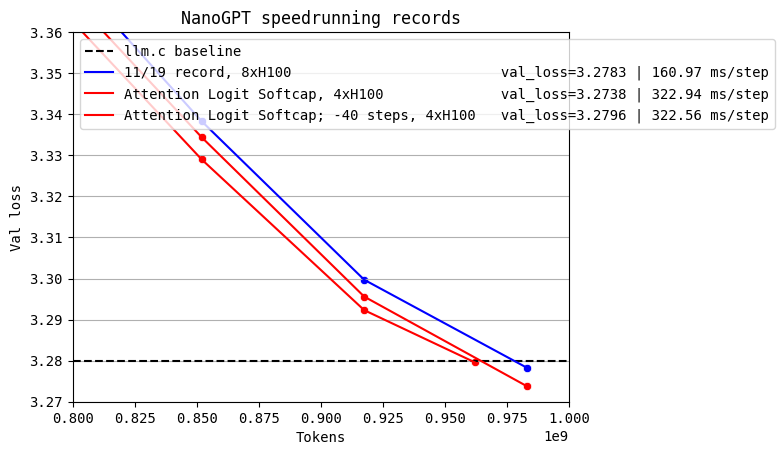

In [7]:
sns.lineplot(x=np.linspace(0.8e9, 1.0e9, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])

    for idx, (tok, val_loss, step_avg_, final_val_loss, label) in enumerate(
        zip(
            train_tokens[offset:offset+n],
            val_losses[offset:offset+n],
            step_avg[offset:offset+n],
            final_val_losses[offset:offset+n],
            labels[offset:offset+n],
        )
    ):
        sns.scatterplot(x=tok, y=val_loss, linewidth=0.5, color=palette[idx])
        final_val_loss = f"{final_val_loss:.4f}"
        sns.lineplot(x=tok, y=val_loss, label=f"{label:<45}val_loss={final_val_loss} | {step_avg_:.2f} ms/step", color=palette[idx])

    offset += n

plt.title("NanoGPT speedrunning records")
plt.legend(loc="upper left")
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
# plt.xlim(1.2e9, 1.6e9)
plt.xlim(0.8e9, 1.0e9)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Tokens")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_tokens.png")

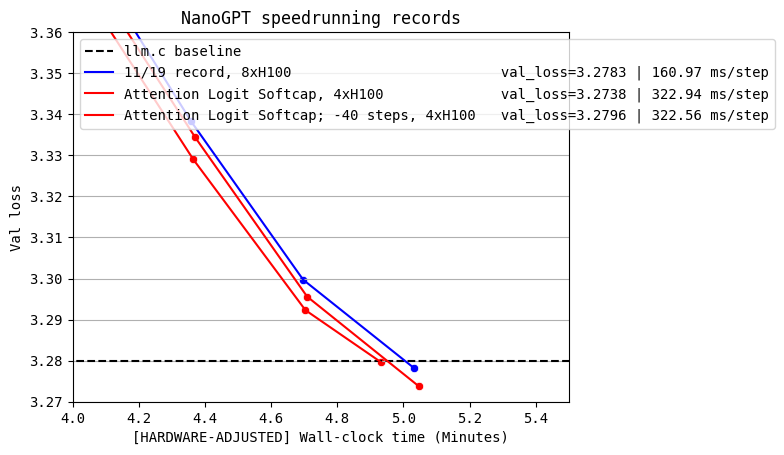

In [8]:
sns.lineplot(x=np.linspace(0, 11, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])

    for idx, (train_times_min_, val_loss, step_avg_, final_val_loss, label) in enumerate(
        zip(
            train_times_min[offset:offset+n],
            val_losses[offset:offset+n],
            step_avg[offset:offset+n],
            final_val_losses[offset:offset+n],
            labels[offset:offset+n],
        )
    ):
        train_times_min_temp = train_times_min_ / 2 if "11/19" not in label else train_times_min_
        sns.scatterplot(x=train_times_min_temp, y=val_loss, linewidth=0.5, color=palette[idx])
        final_val_loss = f"{final_val_loss:.4f}"
        sns.lineplot(x=train_times_min_temp, y=val_loss, label=f"{label:<45}val_loss={final_val_loss} | {step_avg_:.2f} ms/step", color=palette[idx])

    offset += n

plt.title("NanoGPT speedrunning records")
plt.legend(loc="upper left")
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
# plt.xticks(np.arange(0, 34, 2))
plt.xlim(4, 5.5)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("[HARDWARE-ADJUSTED] Wall-clock time (Minutes)")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_wallclock.png")